Name | Matr.Nr. | Due Date
:--- | ---: | ---:
Darina Petrova | 12230205 | 03.06.2024, 10:00

<h1 style="color:rgb(0,120,170)">Hands-on AI II</h1>
<h2 style="color:rgb(0,120,170)">Unit 5 &ndash; Drug Discovery (Assignment)</h2>

<b>Authors:</b> S. Luukkonen (adapted from B. Schäfl, S. Lehner, J. Schimunek, J. Brandstetter, E. Kobler)<br>
<b>Date:</b> 18-04-2023

This file is part of the "Hands-on AI II" lecture material. The following copyright statement applies to all code within this file.

<b>Copyright statement:</b><br>
This material, no matter whether in printed or electronic form, may be used for personal and non-commercial educational use only. Any reproduction of this material, no matter whether as a whole or in parts, no matter whether in printed or in electronic form, requires explicit prior acceptance of the authors.

<h3 style="color:rgb(0,120,170)">How to use this notebook</h3>

This notebook is designed to run from start to finish. There are different tasks (displayed in <span style="color:rgb(248,138,36)">orange boxes</span>) which require your contribution (in form of code, plain text, ...). Most/All of the supplied functions are imported from the file <code>u5_utils.py</code> which can be seen and treated as a black box. However, for further understanding, you can look at the implementations of the helper functions. In order to run this notebook, the packages which are imported at the beginning of <code>u5_utils.py</code> need to be installed.

In [1]:
import warnings
warnings.filterwarnings(action=r'ignore', category=UserWarning)

# Import pre-defined utilities specific to this notebook.
import u5_utils as u5

# Import additional utilities needed in this notebook.
import numpy as np
import pandas as pd
import seaborn as sns

from copy import deepcopy
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator 

# Set default plotting style.
sns.set()

# Setup Jupyter notebook (warning: this may affect all Jupyter notebooks running on the same Jupyter server).
u5.setup_jupyter()

# Check minimum versions.
u5.check_module_versions()

%reload_ext autoreload
%autoreload 2

Installed Python version: 3.10 (✓)
Installed numpy version: 1.25.2 (✓)
Installed pandas version: 2.0.3 (✓)
Installed scikit-learn version: 1.3.2 (✓)
Installed matplotlib version: 3.7.3 (✓)
Installed seaborn version: 0.13.2 (✓)
Installed PIL version: 9.0.1 (✓)
Installed rdkit version: 2023.09.6 (✓)


<h2>Loading molecules and extracting information</h2>
The first step of working with molecule data is actually getting them into memory as <tt>RDKit</tt> molecule objects.

<div class="alert alert-warning">
    <b>Exercise 1.1. [3 Points]</b>
    <ul>
        <li>Load the <i>molecule</i> data set <tt>molecules_logP.csv</tt> using the <code>u5.load_molecules_from_csv</code>.</li>
        <li>Print out the number of molecules.</li>
        <li>Visualize the first molecule with its properties.</li>
    </ul>
</div>

7995 molecules loaded from file.


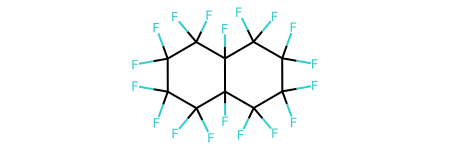

In [2]:
# your code/answer goes here
molecules_logP = u5.load_molecules_from_csv('resources/molecules_logP.csv')
print(f'{len(molecules_logP)} molecules loaded from file.')
mol0 = molecules_logP[0]
mol0

<div class="alert alert-warning">
    <b>Exercise 1.2. [5 Points]</b>
    <ul>
        <li> MW stands for the molecular weight of the molecule. What does the acronym <i>logP</i> stand for? Which property do the extracted molecules share? Cite your sources (find an appropriate source, even if you know it by heart).</li>
    </ul>
</div>

LogP stands for <b>(octanol-water) partition coefficient </b>, it describes how much of the compound dissolves in the water portion versus an organic portion, so how hydrophobic or hydrophilic it is. <br>
Most of the molecules are more  <b>hydrophobic</b>/lipophilic, corresponding to a higher logP value (based on a quick search of how many negative values there were, just looking at the number of minuses '-', which was 809) 

Sources: <br>
https://www.acdlabs.com/wp-content/uploads/download/app/physchem/making_sense.pdf <br>
https://www.biotage.com/blog/what-is-the-role-of-logp-in-sample-prep-methods

<div class="alert alert-warning">
    <b>Exercise 1.3. [2 Points]</b>
    <ul>
        <li> Visualize the distribution of the <i>logP</i> values </li>
    </ul>
</div>

<Axes: ylabel='Count'>

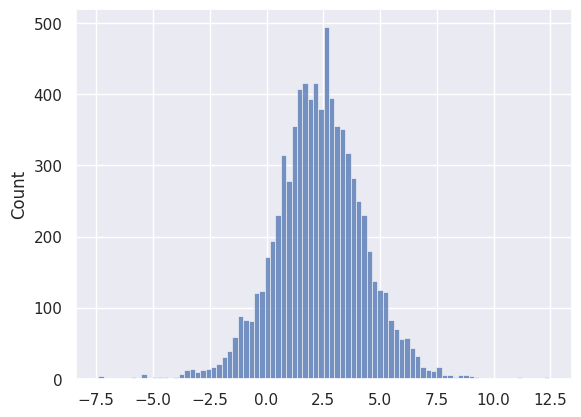

In [3]:
# your code/answer goes here
logP_values = [float(mol.GetProp('logP')) for mol in molecules_logP]

sns.histplot(logP_values)

<div class="alert alert-warning">
    <b>Exercise 1.4. [5 Points]</b>
    <ul>
        <li>Make a selection of molecules by sorting them by their <i>logP</i> values and pick every 1000th molecules.
        <li>Visualize the selected molecules in a <i>$2times 4$ grid</i> including their <i>Formula</i> as well as their <i>logP</i> values.</li>
    </ul>
</div>

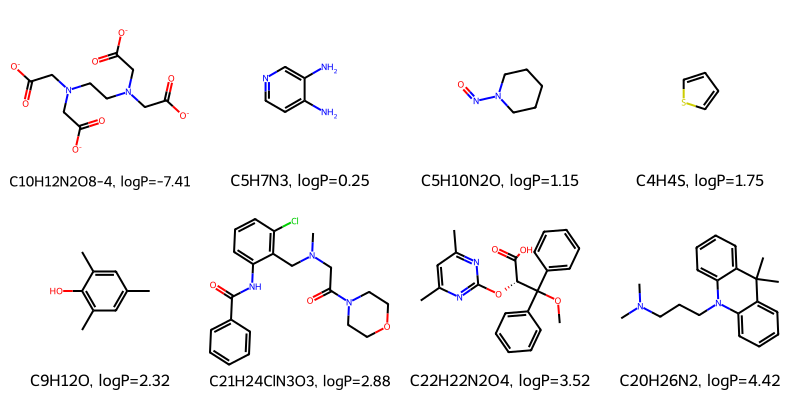

In [4]:
# your code/answer goes here
molecules_sorted = sorted(molecules_logP, key=lambda x: float(x.GetProp('logP')))
molecules_sorted = [mol for i, mol in enumerate(molecules_sorted) if i%1000==0]

labels = [f'{mol.GetProp("Formula")}, logP={mol.GetProp("logP")}' for mol in molecules_sorted]
Chem.Draw.MolsToGridImage(molecules_sorted, molsPerRow=4, legends=labels) 

<div class="alert alert-warning">
    <b>Exercise 1.5. [2 Points]</b>
    <ul>
        <li>Do you observe <i>visually similar</i> molecules? Comment on this.</li>
    </ul>
</div>
        


No, visually they differ quite a lot in my opinion, but the drawings mean very little to me. 6 out of 8 contain Nitrogen, and 5 Oxygen. 

<div class="alert alert-warning">
    <b>Exercise 1.6. [3 Points]</b>
    <ul>
        <li>For each of the previously found molecules, <i>annote</i> each atom by its atom index and compute each molecule's <i>atom count</i>.</li>
        <li>Visualize the result in a <i> $2\times 4$ grid</i> including their <i>Formulas</i> as well as their <i>atom counts</i> (sorted in ascending order according to <i>atom count</i>).</li>
    </ul>
</div>

In [5]:
def annotate_molecule_atoms(molecule: Chem.rdchem.Mol) -> Chem.rdchem.Mol:
    """
    Annotate molecule atoms with corresponding atom numbers.
    
    :param molecule: molecule to annotate
    :return: annotated molecule
    """
    molecule_annotated = deepcopy(molecule)
    for atom in molecule_annotated.GetAtoms():
        atom.SetProp('atomNote', str(atom.GetIdx()))
    return molecule_annotated

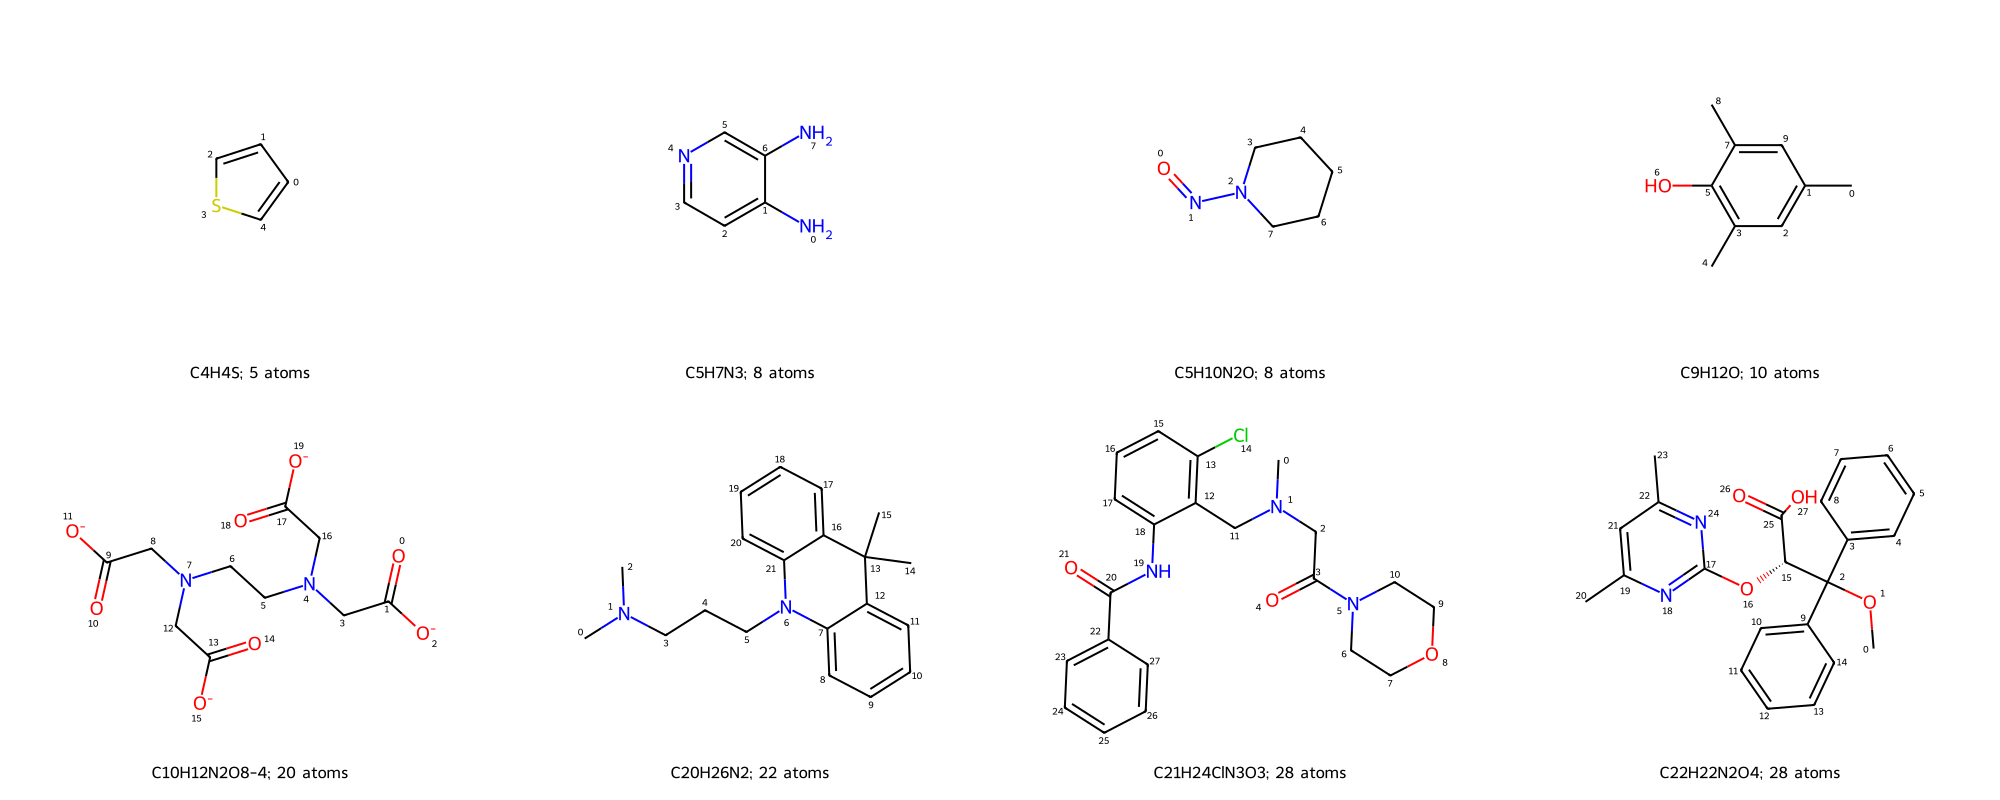

In [6]:
# your code/answer goes here
molecules_annotated = []
for mol in molecules_sorted:
    mol_an = annotate_molecule_atoms(mol)
    atom_count = 0
    for atom in mol_an.GetAtoms(): 
        atom_count+=1
    mol_an.SetProp('atomCount', str(atom_count))
    molecules_annotated.append(mol_an)

molecules_annotated = sorted(molecules_annotated, key=lambda x: float(x.GetProp('atomCount')))

labels = [f'{mol.GetProp("Formula")}; {mol.GetProp("atomCount")} atoms' for mol in molecules_annotated]
Chem.Draw.MolsToGridImage(molecules_annotated, molsPerRow=4, legends=labels, subImgSize=(500, 400)) 

your code/answer goes here

<h2>Atomic Properties and Bonds</h2>
<p>Extracting <i>atomic</i> as well as <i>bond</i> properties often allows for a more thorough undertstanding of the molecules at hand. Unsurprisingly, <tt>RDKit</tt> provides the necessary functionality for this purpose – almost. The missing functionality may be taken from the exercise notebook, but needs to be adapted accordingly.</p>

<div class="alert alert-warning">
    <b>Exercise 2.1. [10 Points]</b>
    <ul>
        <li>Compute the <i>amount of atoms</i> participating in a <i>ring structure</i> for each of the molecules of the previous exercise.</li>
        <li>Adapt and apply <code>annotate_molecule_atoms</code> in a way to annotate an atom with an <tt>R</tt> if it is <i>participating</i> in a ring structure.</li>
        <li>Visualize the result in a <i> $2\times 4$ grid</i> including their <i>Formulas</i> as well as their <i>amount of ring atoms</i> (sorted in descending order according to the latter).</li>
    </ul>
</div>

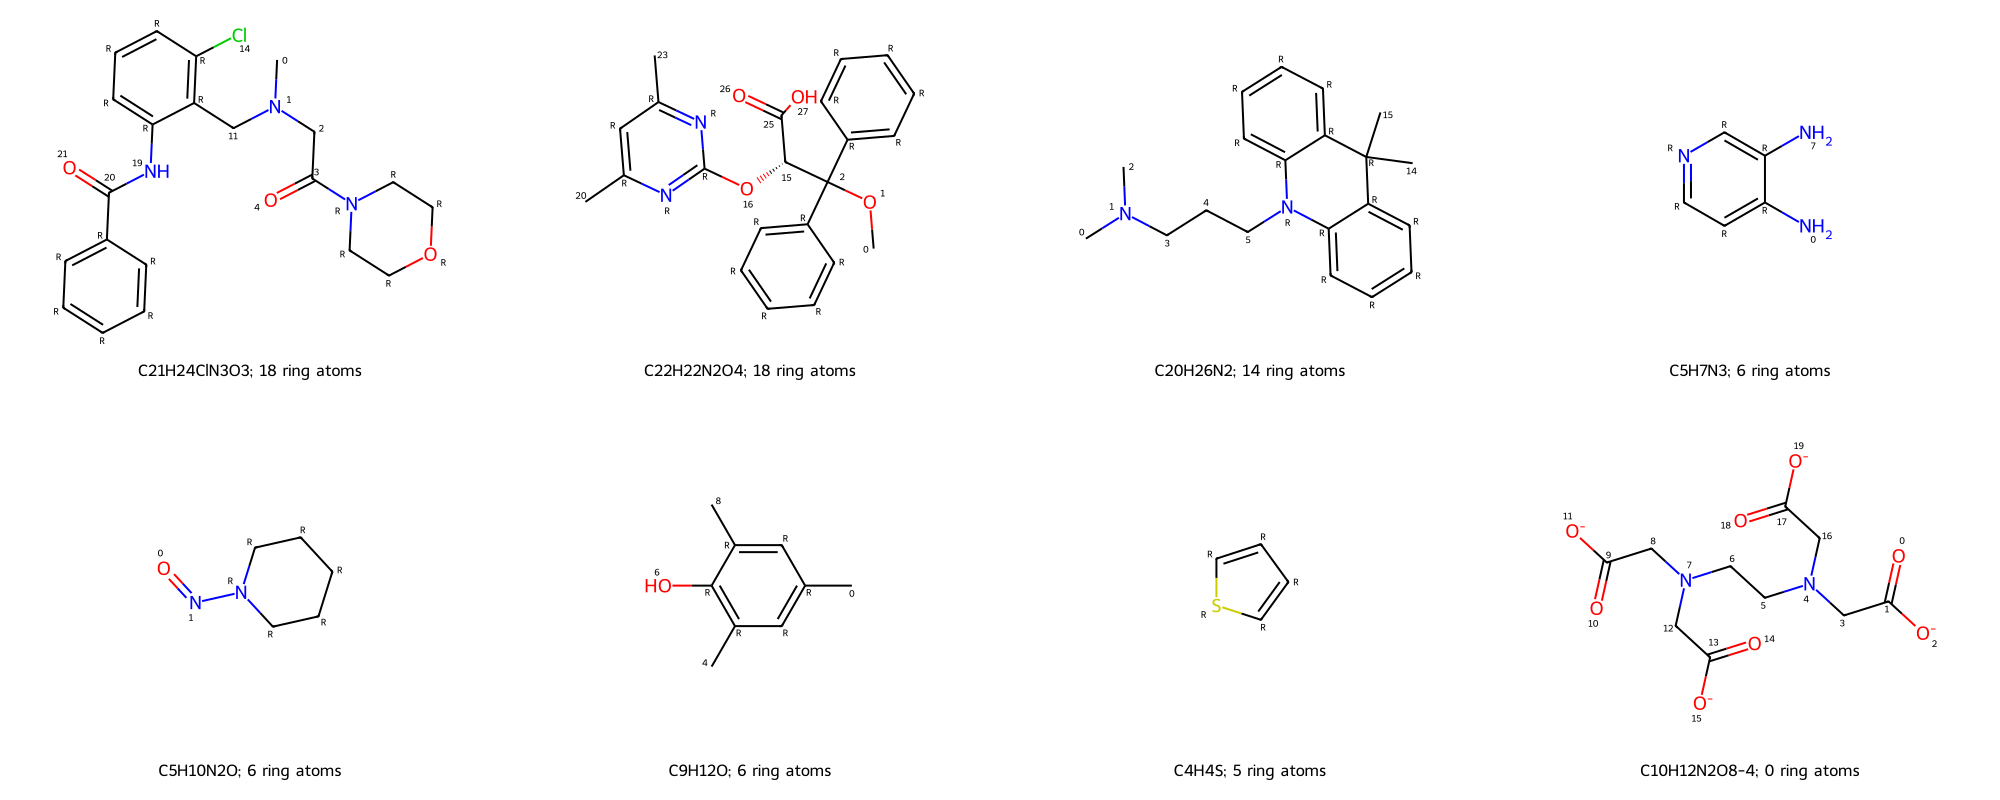

In [7]:
# your code/answer goes here
def annotate_molecule_atoms(molecule):
    molecule_annotated = deepcopy(molecule)
    in_ring = 0
    for atom in molecule_annotated.GetAtoms():
        if atom.IsInRing():
            in_ring+=1
            atom.SetProp('atomNote', 'R')
    return molecule_annotated, in_ring

molecules_annotated_rings = []
for mol in molecules_annotated:
    mol_an, in_ring = annotate_molecule_atoms(mol)
    mol_an.SetProp('amtRingAtoms', str(in_ring))
    molecules_annotated_rings.append(mol_an)

molecules_annotated_rings = sorted(molecules_annotated_rings, reverse=True, key=lambda x: float(x.GetProp('amtRingAtoms')))

labels = [f'{mol.GetProp("Formula")}; {mol.GetProp("amtRingAtoms")} ring atoms' for mol in molecules_annotated_rings]
Chem.Draw.MolsToGridImage(molecules_annotated_rings, molsPerRow=4, legends=labels, subImgSize=(500, 400)) 

<div class="alert alert-warning">
    <b>Exercise 2.2. [10 Points]</b>
    <ul>
        <li>Compute the <i>amount of aromatic bonds</i> for each of the molecules of the previous exercise.</li>
        <li>Adapt and apply <code>annotate_molecule_atoms</code> in a way to mark bonds with the <i>first letter</i> of their respective <i>type</i>.</li>
        <li>Visualize the result in a <i> $2\times 4$ grid</i> including their <i>Formulas</i> as well as their <i>amount of aromatic bonds</i> (sorted in descending order according to the latter).</li>
    </ul>

Hint: You can use `GetIsAromatic` to check if a bond is <a href="https://en.wikipedia.org/wiki/Aromaticity">Aromatic</a>.
</div>


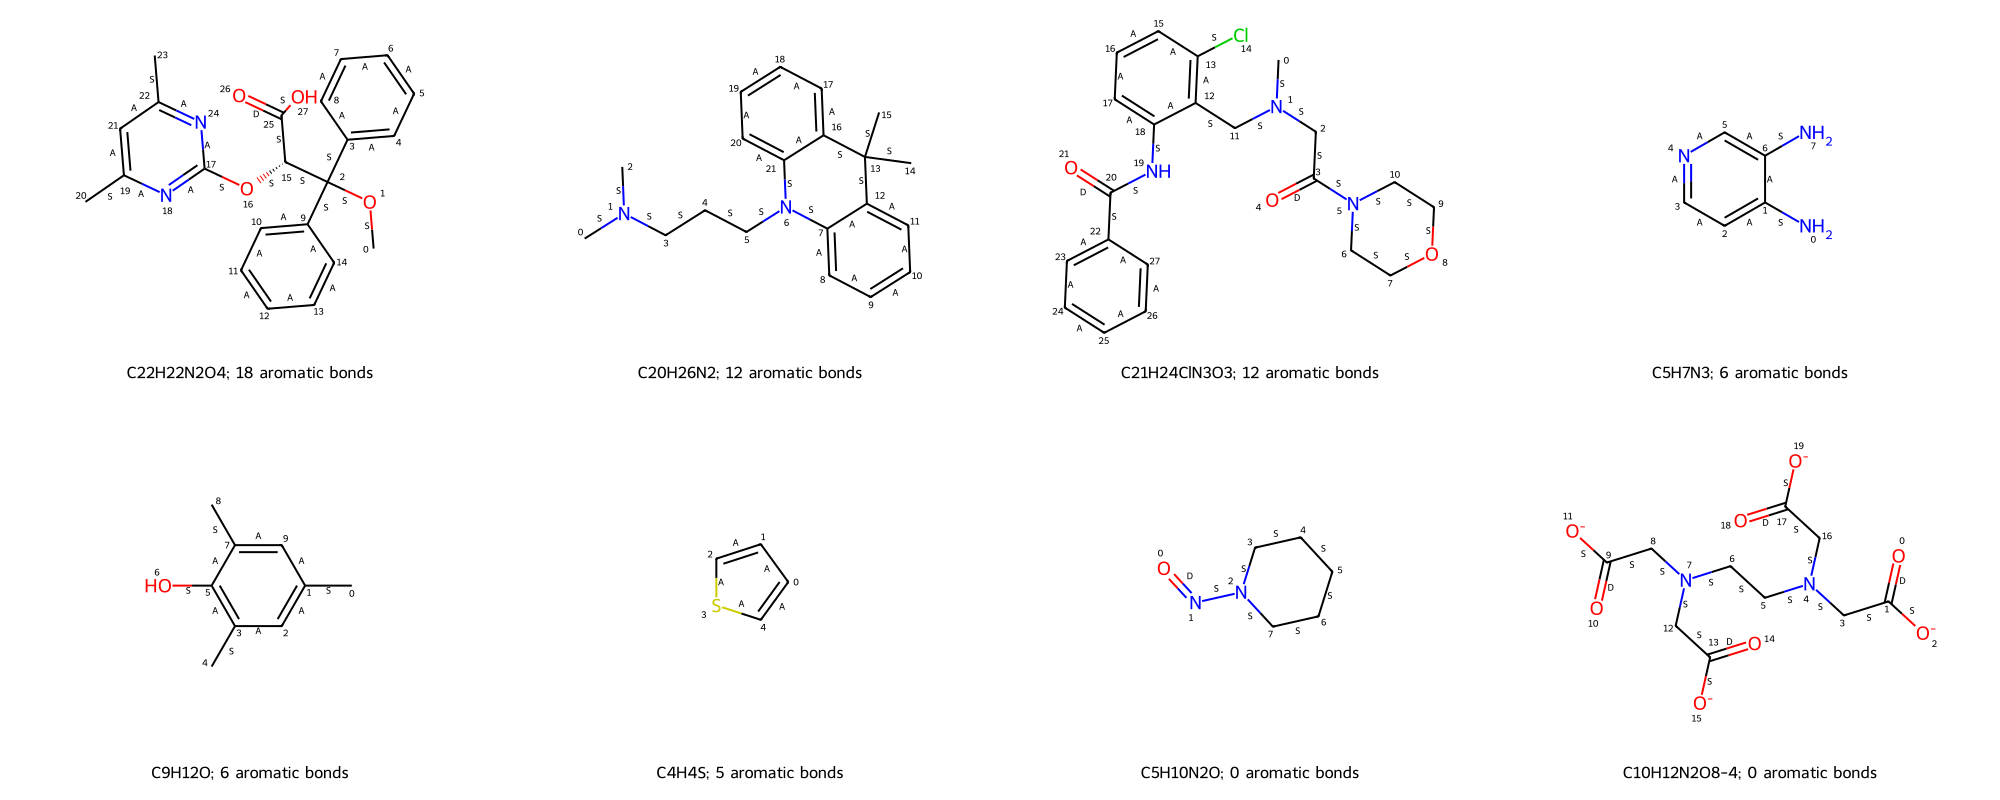

In [8]:
# your code/answer goes here
def annotate_molecule_atoms(molecule):
    molecule_annotated = deepcopy(molecule)
    aromatic = 0
    for bond in molecule_annotated.GetBonds():
        type = str(bond.GetBondType())[0]
        bond.SetProp('bondNote', f'{type}')
        if bond.GetIsAromatic():
            aromatic+=1
    return molecule_annotated, aromatic

molecules_annotated_aromatic = []
for mol in molecules_annotated:
    mol_an, aromatic = annotate_molecule_atoms(mol)
    mol_an.SetProp('amtAromatic', str(aromatic))
    molecules_annotated_aromatic.append(mol_an)

molecules_annotated_aromatic = sorted(molecules_annotated_aromatic, reverse=True, key=lambda x: float(x.GetProp('amtAromatic')))

labels = [f'{mol.GetProp("Formula")}; {mol.GetProp("amtAromatic")} aromatic bonds' for mol in molecules_annotated_aromatic]
Chem.Draw.MolsToGridImage(molecules_annotated_aromatic, molsPerRow=4, legends=labels, subImgSize=(500, 400)) 

<h2>Vizualizing and analyzing the molecular dataset</h2>
<p>In the following exercises, you'll have to dig into analyzing the full dataset.</p>

<div class="alert alert-warning">
    <b>Exercise 3.1. [3 Points]</b>
    <ul>
        <li>Compute Morgan fingerprints with <i>radius</i> of 2 and <i>fingerprint size</i> of 1024 and save them into a pd.DataFrame().</li>
    </ul>
</div>

In [9]:
# your code/answer goes here
mfpgen = rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=1024)
fps = np.array([mfpgen.GetFingerprint(mol) for mol in molecules_logP])
molecules_logP_ecfp = pd.DataFrame(fps)
molecules_logP_ecfp

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7990,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7991,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7992,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7993,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<div class="alert alert-warning">
    <b>Exercise 3.2. [3 Points]</b>
    <ul>
        <li>Plot the fraction of presence of a feature in the molecules of the dataset for each feature.</li>
        <li>Print out the average fraction.</li> 
    </ul>
</div>

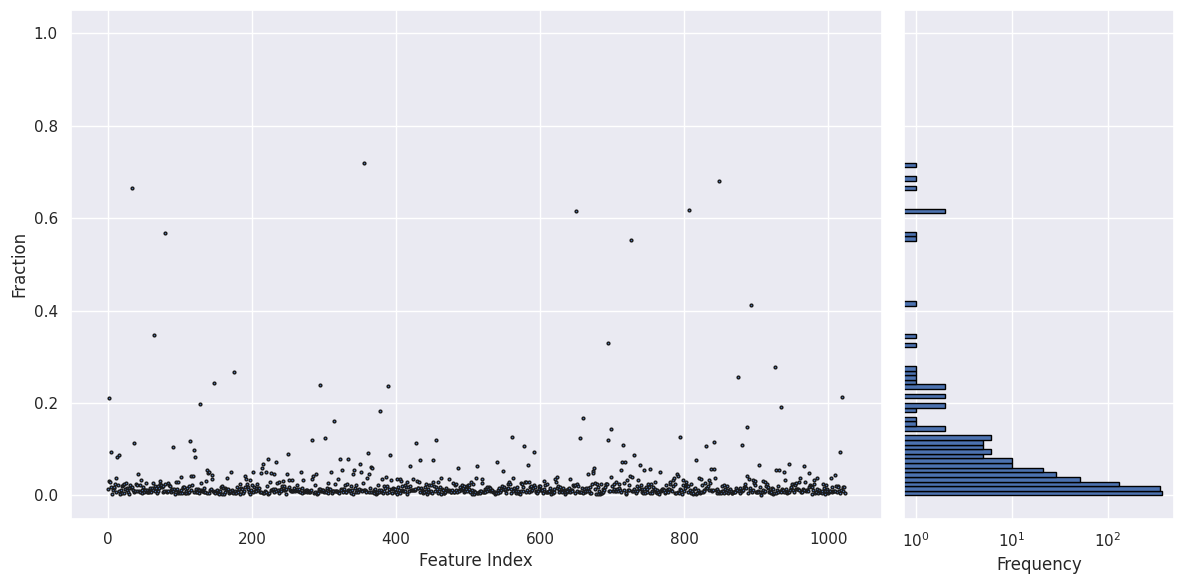

Average fraction of feature presence: 0.03


In [10]:
# your code/answer goes here
u5.plot_feature_fractions(molecules_logP_ecfp)
print(f'Average fraction of feature presence: {molecules_logP_ecfp.mean().mean():.2f}')

<div class="alert alert-warning">
    <b>Exercise 3.3. [3 Points]</b>
    <ul>
        <li>Comment on the presence of the features/subsructures in the dataset and its diversity.</li>
    </ul>
</div>

The average value of fractions of molecules containing a feature is very low, which could indicate a relative high diversity, as it indicates that most substructures are present in only few molecules, but many features seem to not be present at all, indicating low diversity.

<div class="alert alert-warning">
    <b>Exercise 3.4. [5 Points]</b>
    <ul>
        <li>First, reduce the dimensionality of the molecule dataset using <i>PCA</i> to a 32 features, then reduce this 32 features into 2 with <i>t-SNE</i> (use perplexity 10 and seed of 42).</li>
        <li>Bin the logP values into 5 bins.</li>
        <li>Visualize the 2D downprojection with the binned logP values as labels.
    </ul>
</div>

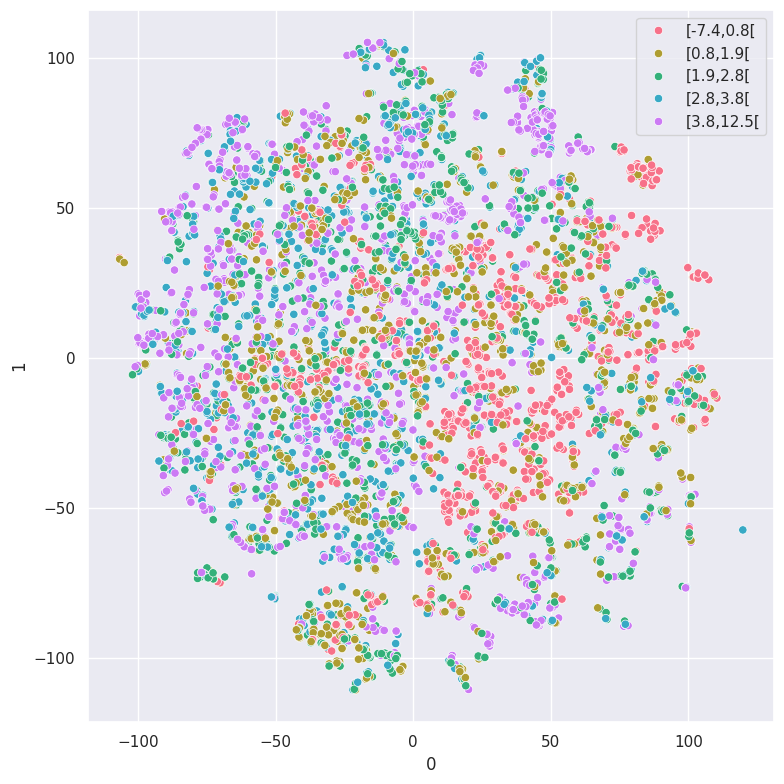

In [11]:
# your code/answer goes here
np.random.seed(seed=42)
molecules_logP_ecfp_pca = u5.apply_pca(n_components=32, data=molecules_logP_ecfp)
np.random.seed(seed=42)
molecules_logP_ecfp_tsne = u5.apply_tsne(n_components=2, data=molecules_logP_ecfp_pca, perplexity = 10.0)

logPs = [float(mol.GetProp('logP')) for mol in molecules_logP]
binned_logPs = u5.bin_contineous_label_values(logPs, num_bins=5)

u5.plot_points_2d(molecules_logP_ecfp_tsne, targets=binned_logPs, figsize=(8, 8))

<div class="alert alert-warning">
    <b>Exercise 3.5. [3 Points]</b>
    <ul>
        <li>Are there any visible clusters? In the structure of the downprojection or the binned logP labels?
    </ul>
</div>

Not really, in general the lower values logP have a higher concentration on the right side and the higher values on the left (most visible in the extremum bins), but they are all still pretty intertwined. Because of the frequency distribution, the extremum binned logP label ranges are big (8.2 and 8.7), while the ones in the middle are small, with ranges around 1.

<div class="alert alert-warning">
    <b>Exercise 3.6. [3 Points]</b>
    <ul>
        <li>Cluster the dataset with <i>Sphere exclusion clustering</i> with threshold of 0.96 on the raw fingerprints.</li>
        <li>Print the number of clusters.</li>
        <li>Visualize the TSNE downproject with the cluster indices as labels. Turn of the legend.</li>
    </ul>
</div>

Number of clusters: 9


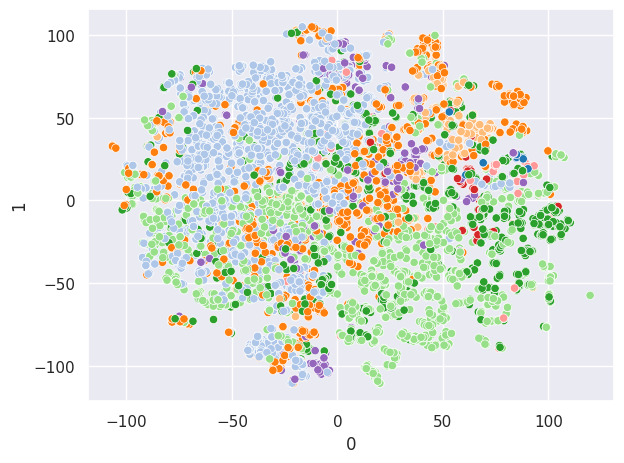

In [12]:
# your code/answer goes here
np.random.seed(seed=42)
clusters = u5.apply_sphere_exclusion_clustering(data=molecules_logP_ecfp, th=0.96)
print('Number of clusters:', len(set(clusters)))

u5.plot_points_2d(molecules_logP_ecfp_tsne, targets=clusters, legend=False, multi_color_palette='tab20')

<div class="alert alert-warning">
    <b>Exercise 3.7. [3 Points]</b>
    <ul>
        <li>Comment on the separability of the molecule clusters with respect to the downprojection.</li>
    </ul>
</div>

The clusters are not well separated, meaning the downprojection did not do well.

<div class="alert alert-warning">
    <b>Exercise 3.8. [5 Points]</b>
    <ul>
        <li>Compute the sizes of the clusters and print out the size of the smallest, median and largest clusters.</li>
    </ul>
    Hint: the <code>Counter</code> from the <code>collections</code> package might be useful.
</div>

In [13]:
# your code/answer goes here
import collections

sizes = collections.Counter(clusters)
pairs = list(sizes.items())
pairs = sorted(pairs, key=lambda x: x[1])
median = len(pairs)//2

print(f'Size of smallest cluster: {pairs[0][1]}, median: {pairs[median][1]} and largest: {pairs[-1][1]}')

Size of smallest cluster: 28, median: 464 and largest: 2567


<div class="alert alert-warning">
    <b>Exercise 3.9. [3 Points]</b>
    <ul>
        <li>Plot <i>the first 30</i> molecules of the <i>median cluster</i> in a grid with their <i>Formula</i>.</li>
    </ul>
</div>

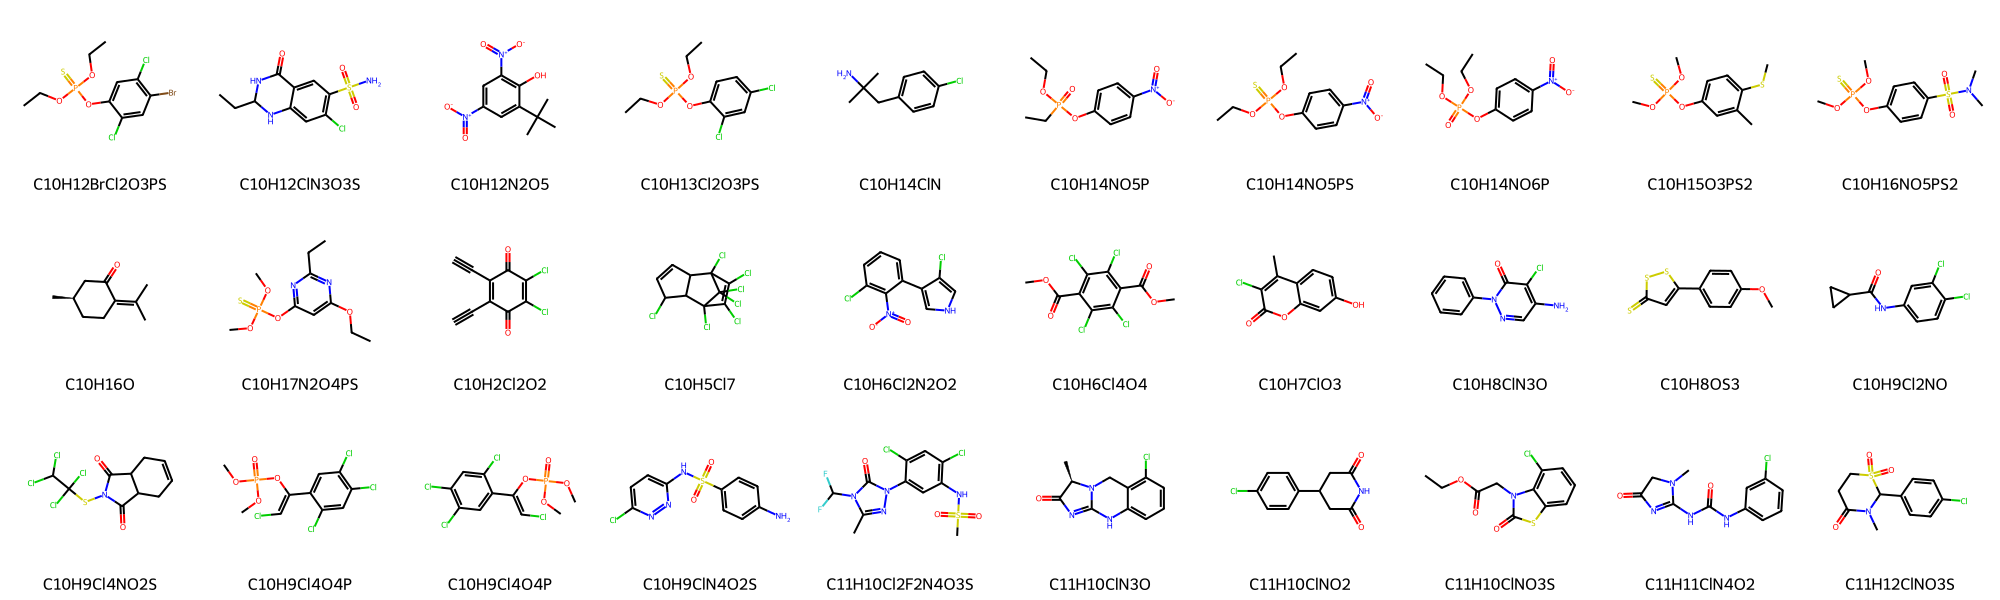

In [14]:
# your code/answer goes here
median_cluster_nr = pairs[median][0]

cluster_indices = [i for i, cluster_id in enumerate(clusters) if cluster_id == median_cluster_nr]
cluster_indices = cluster_indices[:30]
cluster_molecules = [molecules_logP[i] for i in cluster_indices]
cluster_molecule_labels = [f'{mol.GetProp("Formula")}' for mol in cluster_molecules]

# Plot specified molecules with extracted properties as labels in a grid plot.
Chem.Draw.MolsToGridImage(
    cluster_molecules,
    legends=cluster_molecule_labels,
    maxMols=30,
    molsPerRow=10
)

<div class="alert alert-warning">
    <b>Exercise 3.10. [3 Points]</b>
    <ul>
        <li>Comment the structures of the molecules in the median cluster. Do you see any common chemical substructures in the cluster. If yes what? Do you see any outlier?
    </ul>
</div>

They seem similar, but varied enough - each has 1 or 2 rings and atoms like Oxygen, Sulfur, Chloride, Nitrogen.
<br> C10H9Cl2NO (row 2 column 10) looks different from the rest, since it has a 3 sided ring.

<h2>Quantitative structure-<i>property</i> relationship modeling</h2>
<p>In the following exercises, you'll have to build QSPR models to predict the logP value of the molecules.</p>

<div class="alert alert-warning">
    <b>Exercise 4.1. [5 Points]</b>
    <ul>
        <li>Create a dataframe containing the Morgan fingerprints, the logP value and the cluster id for each molecule of dataset.</li>
        <li>Divide the dataset into a training and test set with the <i>cluster split</i> with a test set fraction of approximately 20%.</li>
        <li>Print the training and test set sizes.</li>
        <li>Visualize the data split in the downprojection.</li>
    </ul>
</div>

Train set size:	 7053	 (0.88)
Test set size:	 942	 (0.12)


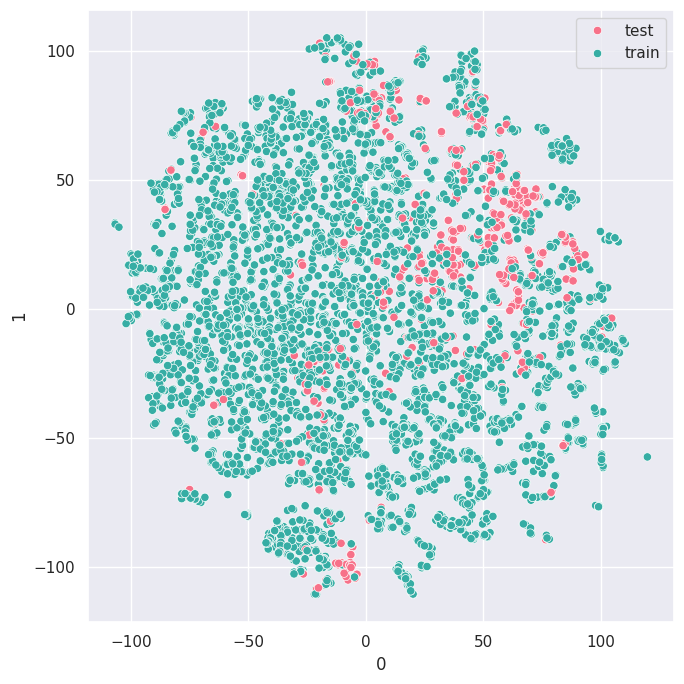

In [15]:
# your code/answer goes here
molecules_logP_ecfp['LogP'] = logPs
molecules_logP_ecfp['Cluster'] = clusters
molecules_logP_ecfp

data_train, data_test = u5.apply_cluster_split(molecules_logP_ecfp, test_size=0.20)
print(f'Train set size:\t {data_train.shape[0]}\t ({data_train.shape[0]/(molecules_logP_ecfp.shape[0]):.2f})')
print(f'Test set size:\t {data_test.shape[0]}\t ({data_test.shape[0]/(molecules_logP_ecfp.shape[0]):.2f})')

labels = ['train' if i in data_train.index else 'test' for i in molecules_logP_ecfp.index]
u5.plot_points_2d(molecules_logP_ecfp_tsne.loc[molecules_logP_ecfp.index], targets=labels, figsize=(7,7))

<div class="alert alert-warning">
    <b>Exercise 4.2. [5 Points]</b>
    <ul>
        <li>With the help of <code>u5.train_and_evalute_sklearn_regressor</code> train and evaluate a <tt>sklearn</tt>'s <a hhref="https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor"><code>RandomForestRegressor</code></a> with <i>default parameters</i>.
        <li>Comment on the performace of the model.</li>
    </ul>
</div>

Train spearmanr_score: 0.982
Test spearmanr_score: 0.746


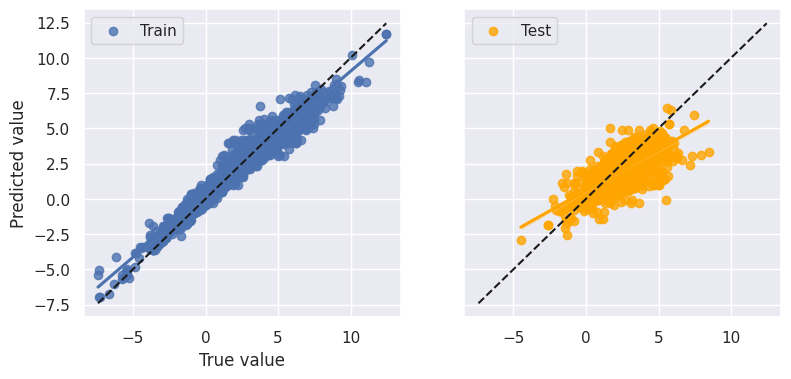

In [16]:
# your code/answer goes here
from sklearn.ensemble import RandomForestRegressor
_ = u5.train_and_evaluate_sklearn_regressor(
    model = RandomForestRegressor(),
    X_train=data_train.drop(['LogP', 'Cluster'], axis=1).values,
    y_train=data_train['LogP'].values,
    X_test=data_test.drop(['LogP', 'Cluster'], axis=1).values,
    y_test=data_test['LogP'].values,
    metric = u5.spearmanr_score,
)

The train set slightly overfits, the predicted values are very highly correlated with the true values. The test set does worse, with the correlation being only moderate to high (0.75), but still does pretty well.

<div class="alert alert-warning">
    <b>Exercise 4.3. [15 Points]</b>
    <ul>
        <li>Create a model and train is so that you have a test set mean squarred error below 1.3.</li>
        <li>Keep the same train-test split for a fair comparison, but outside of that you can do want ever you want (i.e. change the features, model type, hyperparameters...).</li>
    </ul>
    Hints:
    <ul>
        <li>Take a look at the different ML models implemented in <tt>sklearn</tt> <a href="https://scikit-learn.org/stable/supervised_learning.html">here</a>.</li>
        <li>You can also use a non-<tt>sklearn</tt> model (<i>e.g.</i>, <tt>Pytorch</tt>) in which case evaluate your test set performance with <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error"><code>mean_squared_error</code></a> from <tt>sklearn</tt>.</li>
    </ul>    
</div>

In [17]:
# your code/answer goes here
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

X_train=data_train.drop(['LogP', 'Cluster'], axis=1).values
y_train=data_train['LogP'].values
X_test=data_test.drop(['LogP', 'Cluster'], axis=1).values
y_test=data_test['LogP'].values

regr = MLPRegressor(random_state=1, hidden_layer_sizes=(100,200,100), max_iter=500, early_stopping=True).fit(X_train, y_train)

regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Test set mean squared error: ', mse)

Test set mean squared error:  1.07701769453913
